In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate
from scipy.stats import norm

from tropical_cyclone_dm import TropicalCycloneSequenceDataModule

plt.rcParams["figure.figsize"] = [14, 5]

color_palette = {
    # Classification
    "DKLClassification": "#2ca02c",  # Green
    "LaplaceClassification": "#d62728",  # Red
    "DeepEnsembleClassification": "#9467bd",  # Purple
    "MCDropoutClassification": "#8c564b",  # Brown
    "SWAGClassification": "#e377c2",  # Pink
    "BNN_VI_ELBO_Classification": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUEClassification": "#17becf",  # Teal
    "DeterministicClassification": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDClassification": "#98df8a",
    "TempScaling": "#ff9896",  # Light Red
    "RAPS": "#c5b0d5",  # Light Purple
    # regression
    "MVERegression": "#1f77b4",  # Blue
    "QuantileRegression": "#ff7f0e",  # Orange
    "DKLRegression": "#2ca02c",  # Green
    "LaplaceRegression": "#d62728",  # Red
    "DeepEnsembleRegression": "#9467bd",  # Purple
    "MCDropoutRegression": "#8c564b",  # Brown
    "SWAGRegression": "#e377c2",  # Pink
    "BNN_VI_ELBO_Regression": "#7f7f7f",  # Gray
    "BNN_VI_Regression": "#bcbd25",  # Lime
    "DER": "#bcbd22",  # Lime
    "DUERegression": "#17becf",  # Teal
    "DeterministicRegression": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDRegression": "#98df8a",
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "empirical_cov": "Empirical Coverage",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "calibration": "Calibration",
    "correlation": "Correlation",
    "nll": "NLL",
    "mace": "MACE",
    "crps": "CRPS",
    "proportion_in_0.9_interval": "Proportion in 0.9 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "DKLClassification": "DKL",
    "LaplaceClassification": "Laplace",
    "DeepEnsembleClassification": "Deep Ensemble",
    "MCDropoutClassification": "MC Dropout",
    "SWAGClassification": "SWAG",
    "BNN_VI_ELBO_Classification": "BNN VI ELBO",
    "DUEClassification": "DUE",
    "DeterministicClassification": "Deterministic",
    "CARDClassification": "CARD",
    "MVERegression": "MVE",
    "QuantileRegression": "Quantile",
    "DKLRegression": "DKL",
    "LaplaceRegression": "Laplace",
    "DeepEnsembleRegression": "Deep Ensemble",
    "MCDropoutRegression": "MC Dropout",
    "SWAGRegression": "SWAG",
    "BNN_VI_ELBO_Regression": "BNN VI ELBO",
    "BNN_VI_Regression": "BNN VI",
    "DER": "DER",
    "DUERegression": "DUE",
    "DeterministicRegression": "Deterministic",
    "ConformalQR": "Conformal QR",
    "CARDRegression": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    #"/p/project/hai_uqmethodbox/experiment_output/test_class_digital_34",
    #"/p/project/hai_uqmethodbox/experiment_output/reg_digital_34",
    "/p/project/hai_uqmethodbox/experiment_output/test_class",
    "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new",
]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
    if os.path.exists(os.path.join(os.path.dirname(file), "config.yaml"))
]


# selective prediction threshold
SELECTIVE_THRESH = 12

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
STORM_DISPLAY_ORDER = ["all", "TD", "TS", "H1", "H2", "H3", "H4", "H5"]

DS_SPLIT = "test"


# Define your lists of methods
CLASSIFICATION_METHODS = [
    "DeterministicClassification",
    "DeepEnsembleClassification",
    "MCDropoutClassification",
    "SWAGClassification",
    "LaplaceClassification",
    "BNN_VI_ELBO_Classification",
    "DKLClassification",
    "DUEClassification",
    "RAPS",
    # "TTAClassification",
    "TempScaling"
]

REGRESSION_METHODS = [
    'DeterministicRegression',
    "MVERegression",
    "DeepEnsembleRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "LaplaceRegression",
    "BNN_VI_Regression",
    "DER",
    "BNN_VI_ELBO_Regression",
    "DKLRegression",
    "DUERegression",
    "QuantileRegression",
    'ConformalQR',
    "CARDRegression"
]


UQ_METHOD_DISPLAY_ORDER = {
    "Classification": [
        "DeterministicClassification",
        "TempScaling",
        "RAPS",
        "MCDropoutClassification",
        "SWAGClassification",
        "LaplaceClassification",
        "BNN_VI_ELBO_Classification",
        "DKLClassification",
        "DUEClassification",
        "DeepEnsembleClassification",
        "CARDClassification",
    ],
    "Regression": [
        "DeterministicRegression",
        "MVERegression",
        "DER",
        "QuantileRegression",
        "ConformalQR",
        "MCDropoutRegression",
        "SWAGRegression",
        "LaplaceRegression",
        "BNN_VI_Regression",
        "BNN_VI_ELBO_Regression",
        "DKLRegression",
        "DUERegression",
        "DeepEnsembleRegression",
        "CARDRegression",
    ],
}

# Define the groups
UQ_METHOD_GROUPS = {
    "Deterministic": ["MVERegression", "DER"],
    "Quantile": ["QuantileRegression", "ConformalQR"],
    "Bayesian": [
        # classification
        "MCDropoutClassification",
        "SWAGClassification",
        "LaplaceClassification",
        "BNN_VI_ELBO_Classification",
        "DKLClassification",
        "DUEClassification",
        # regression
        "MCDropoutRegression",
        "SWAGRegression",
        "LaplaceRegression",
        "BNN_VI_ELBO_Regression",
        "BNN_VI_Regression",
        "DKLRegression",
        "DUERegression",
    ],
    "Ensemble": ["DeepEnsembleClassification", "DeepEnsembleRegression"],
    "Diffusion": ["CARDRegression"],
}

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_

In [4]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = re.sub(r"preds_.*\.csv", "config.yaml", path)
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        conf = OmegaConf.load(exp_dict["conf_path"])
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,SWAGClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
1,SWAGClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
2,SWAGClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
3,DKLClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
4,DKLClassification,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
...,...,...,...,...
67,DER,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
68,DER,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
69,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
70,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...


In [5]:
with pd.option_context("display.max_colwidth", None):
    display(overview_df.conf_path)

0          /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/config.yaml
1          /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/config.yaml
2          /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/config.yaml
3           /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/config.yaml
4           /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/config.yaml
                                                                   ...                                                              
67              /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DER_02-01-2024_08-40-15-469560/config.yaml
68              /p/project/hai_uqmethodbox/experiment_output/min_wind

In [6]:
datamodule = instantiate(OmegaConf.load(overview_df.conf_path.iloc[0]).datamodule)
datamodule.setup("fit")
datamodule.setup(stage="test")

In [7]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))
# ds = datamodule.test_dataset.dataset
bin_size = 5
WIND_SPEED_BINS = list(
            range(
                0,
                180+ 2*bin_size,
                bin_size,
            )
        )


DS_DICT = {"train": dataset, "val": dataset, "test": test_ds}
print(WIND_SPEED_BINS), print(len(WIND_SPEED_BINS))

69267
56348
10335
2584
43635
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185]
38


(None, None)

In [8]:
bin_intervals = np.diff(WIND_SPEED_BINS)
bin_intervals = (np.append(bin_intervals, bin_intervals[-1]) / 2) + WIND_SPEED_BINS
bin_intervals, len(bin_intervals)

(array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
         92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
        137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
        182.5, 187.5]),
 38)

In [9]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule

    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()


def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, "config.yaml"))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(get_normalization_params_from_df_wrapper, paths),
                total=len(paths),
            )
        )
    results = {
        k: v for result in results if result is not None for k, v in result.items()
    }
    return results


num_processes = 8
os.environ["HYDRA_FULL_ERROR"] = "1"
dir_paths = list(
    set(
        [
            os.path.dirname(path)
            for path in paths
            if any(
                condition in path for condition in ["Regression", "ConformalQR", "DER"]
            )
        ]
    )
)
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(
    dir_paths, num_processes
)
NORMALIZATION_PARAMS

100%|██████████| 14/14 [01:14<00:00,  5.29s/it]


{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DUERegression_02-01-2024_08-40-15-469591': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_Regression_02-26-2024_10-40-18-557918': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeepEnsembleRegression_02-02-2024_15-09-32-001250': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_QuantileRegression_02-01-2024_08-40-15-469579': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445': {'target_mean': 50.34400842620664,
  'target_std': 26.79527730710875},
 '/p/project/hai_uqmeth

# Compute all predictions full df

In [10]:
import pandas as pd

from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import trange, tqdm
from joblib import Parallel, delayed



def fit_gaussian(x, mean, std_dev):
    return norm.pdf(x, mean, std_dev)


def fit_gaussian_to_row(row, bin_midpoints):
    p0 = [np.mean(row), np.std(row) + 1e-5]
    try:
        popt, _ = curve_fit(fit_gaussian, bin_midpoints, row, p0=p0, maxfev=2000)
    except RuntimeError:
        print(row)
        print(bin_midpoints)
    return popt


def process_overview_df(overview_df):
    overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

    all_test_pred_df = []
    for idx, row in overview_df.iterrows():
        pred_df = pd.read_csv(row["pred_path"])
        pred_df["uqmethod"] = row["uqmethod"]
        if row["split"] == "preds.csv":
            pred_df["split"] = "preds_test"
        else:
            pred_df["split"] = row["split"].split(".")[0]

        pred_df["pred_path"] = row["pred_path"]
        all_test_pred_df.append(pred_df)

    all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

    # all_test_pred_df = all_test_pred_df[(all_test_pred_df["uqmethod"] == "DKLClassification") & (all_test_pred_df["split"] == "preds_test")]

    # date
    pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

    # Extract dates and create a new column
    all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

    # Convert the new_date_column to datetime format
    all_test_pred_df["date"] = pd.to_datetime(
        all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
    )

    def compute_bin_mean_prediction(x, bin_edges):
        # x = row["pred"]
        if x < len(bin_edges) - 1:
            return (bin_edges[x] + bin_edges[x + 1]) / 2
        else:
            # extend the last category bin
            return (bin_edges[x] + dataset.class_bin_size) / 2

    # argmax Classification prediction
    pattern = "|".join(CLASSIFICATION_METHODS)
    if any(all_test_pred_df["pred_path"].str.contains(pattern)):
        # argmax Classification prediction
        all_test_pred_df["argmax_reg"] = all_test_pred_df.apply(
            lambda row: (
                compute_bin_mean_prediction(int(row["pred"]), WIND_SPEED_BINS)
                if any(condition in row["uqmethod"] for condition in CLASSIFICATION_METHODS)
                else np.nan
            ),
            axis=1,
        )

        # weighted softmax Classification prediction
        logit_cols = [
            col for col in all_test_pred_df.columns if col.startswith("logit_")
        ]

        # Compute softmax values for each logit
        exp_logits = all_test_pred_df.loc[
            all_test_pred_df["uqmethod"].str.contains(pattern), logit_cols
        ].values.copy()
        softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        # Compute bin intervals
        bin_intervals = np.diff(WIND_SPEED_BINS) / 2
        bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

        # Compute weighted average of the softmax over the logits
        all_test_pred_df.loc[
            all_test_pred_df["uqmethod"].str.contains(pattern), "softmax_weighted_reg"
        ] = np.sum(softmax_values * bin_midpoints, axis=1)

        k = 5

        # Get the logit columns
        logit_cols = [col for col in all_test_pred_df.columns if col.startswith('logit_')]

        # Filter the DataFrame for classification methods with nan in pred_set column
        classification_df = all_test_pred_df[all_test_pred_df["uqmethod"].str.contains(pattern)]
        classification_df = classification_df[classification_df['pred_set'].isna()]

        # Find the logit indices of the top k predictions
        top_k_indices = np.argsort(-classification_df[logit_cols].values, axis=1)[:, :k]

        # Form a set of the top k logit indices for each row
        classification_df[f"top_{k}_logits"] = [set(indices) for indices in top_k_indices]

        # Update the original dataframe with the new column
        # all_test_pred_df.update(classification_df)
        all_test_pred_df.loc[classification_df.index, f"top_{k}_logits"] = classification_df[f"top_{k}_logits"]

    # all_test_pred_df['argmax_reg'] = all_test_pred_df.apply(lambda row: compute_bin_mean_prediction(row, WIND_SPEED_BINS), axis=1)

    # # weighted softamx Classification prediction
    # logit_cols = [col for col in all_test_pred_df.columns if col.startswith('logit_')]

    # # Compute softmax values for each logit
    # exp_logits = np.exp(all_test_pred_df[logit_cols].values.copy())
    # softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # # Compute bin intervals
    # bin_intervals = np.diff(WIND_SPEED_BINS) / 2
    # bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

    # # Compute weighted average of the softmax over the logits
    # all_test_pred_df['softmax_weighted_reg'] = np.sum(softmax_values * bin_midpoints, axis=1)

    # logits = all_test_pred_df[logit_cols].values

    # logits_softplus = np.log1p(np.exp(logits))
    # logits_softplus_sum = np.sum(logits_softplus, axis=1, keepdims=True)
    # # logits_softplus_normalized = logits_softplus / logits_softplus_sum
    # logits_softplus_sum += 1e-3

    # # Fit a Gaussian to the softmax logits
    # gaussian_params = Parallel(n_jobs=12)(delayed(fit_gaussian_to_row)(row, np.arange(len(logit_cols))) for row in tqdm(logits_softplus_sum, desc="Fitting Gaussians"))
    # # Convert the list of tuples into a DataFrame
    # gaussian_params_df = pd.DataFrame(gaussian_params, columns=['gaussian_mean', 'gaussian_std'])

    # # # Assign the columns of the DataFrame to new columns in all_test_pred_df
    # all_test_pred_df[['gaussian_mean', 'gaussian_std']] = gaussian_params_df

    all_test_pred_df = all_test_pred_df.reset_index(drop=True)

    # Create a new column 'method_type' in the DataFrame
    all_test_pred_df['method_type'] = all_test_pred_df['uqmethod'].apply(lambda x: 'Classification' if x in CLASSIFICATION_METHODS else ('Regression' if x in REGRESSION_METHODS else 'Unknown'))

    
    mask = all_test_pred_df['method_type'] == 'Regression'
    all_test_pred_df.loc[mask, 'TARGET_MEAN'] = all_test_pred_df.loc[mask, 'pred_path'].map(lambda x: NORMALIZATION_PARAMS[os.path.dirname(x)]['target_mean'])
    all_test_pred_df.loc[mask, 'TARGET_STD'] = all_test_pred_df.loc[mask, 'pred_path'].map(lambda x: NORMALIZATION_PARAMS[os.path.dirname(x)]['target_std'])

    # Apply normalization only to those rows
    all_test_pred_df.loc[mask, "pred"] = all_test_pred_df.loc[mask, "pred"] * all_test_pred_df.loc[mask, 'TARGET_STD'] + all_test_pred_df.loc[mask, 'TARGET_MEAN']
    all_test_pred_df.loc[mask, "target"] = all_test_pred_df.loc[mask, "target"] * all_test_pred_df.loc[mask, 'TARGET_STD'] + all_test_pred_df.loc[mask, 'TARGET_MEAN']
    all_test_pred_df.loc[mask, "pred_uct"] = all_test_pred_df.loc[mask, "pred_uct"] * all_test_pred_df.loc[mask, 'TARGET_STD']

    # if "wind_speed" column has nans, copy the "target" column to "wind_speed"
    all_test_pred_df["wind_speed"] = all_test_pred_df["wind_speed"].fillna(all_test_pred_df["target"])

    # if argmax_reg column has nans, copy the pred column to a new column called point_pred
    all_test_pred_df["point_pred"] = all_test_pred_df["argmax_reg"].fillna(all_test_pred_df["pred"])

    # compute squared error
    all_test_pred_df["mse"] = (all_test_pred_df["point_pred"] - all_test_pred_df["wind_speed"]) ** 2
    # compute mean absolute error
    all_test_pred_df["mae"] = np.abs(all_test_pred_df["point_pred"] - all_test_pred_df["wind_speed"])

    all_test_pred_df["storm_category"] = pd.cut(
        all_test_pred_df["wind_speed"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
    )

    # for RAPS uqmethod, pred_uct should be the size column
    # all_test_pred_df.loc[
    #     all_test_pred_df["uqmethod"] == "RAPS", "pred_uct"
    # ] = all_test_pred_df.loc[all_test_pred_df["uqmethod"] == "RAPS", "size"]
    # Convert the strings in 'pred_set' column to lists
    all_test_pred_df.loc[all_test_pred_df['pred_set'].notnull(), 'pred_set'] = all_test_pred_df.loc[all_test_pred_df['pred_set'].notnull(), 'pred_set'].apply(lambda x: set([int(i) for i in x.strip('[]').split(', ')]))

    # where pred_set is nan, copy top k logits to pred_set
    all_test_pred_df.loc[all_test_pred_df['pred_set'].isna(), 'pred_set'] = all_test_pred_df.loc[all_test_pred_df['pred_set'].isna(), f'top_{k}_logits']
    

    return all_test_pred_df


all_test_pred_df = process_overview_df(overview_df)
print(all_test_pred_df.columns)
all_test_pred_df

Index(['pred', 'pred_uct', 'target', 'storm_id', 'index', 'wind_speed',
       'logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 'logit_5',
       'logit_6', 'logit_7', 'logit_8', 'logit_9', 'logit_10', 'logit_11',
       'logit_12', 'logit_13', 'logit_14', 'logit_15', 'logit_16', 'logit_17',
       'logit_18', 'logit_19', 'logit_20', 'logit_21', 'logit_22', 'logit_23',
       'logit_24', 'logit_25', 'logit_26', 'logit_27', 'logit_28', 'logit_29',
       'logit_30', 'logit_31', 'logit_32', 'logit_33', 'logit_34', 'logit_35',
       'logit_36', 'logit_37', 'uqmethod', 'split', 'pred_path',
       'relative_time', 'ocean', 'size', 'pred_set', 'epistemic_uct',
       'aleatoric_uct', 'lower_quant', 'upper_quant', 'date', 'argmax_reg',
       'softmax_weighted_reg', 'top_5_logits', 'method_type', 'TARGET_MEAN',
       'TARGET_STD', 'point_pred', 'mse', 'mae', 'storm_category'],
      dtype='object')


,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,argmax_reg,softmax_weighted_reg,top_5_logits,method_type,TARGET_MEAN,TARGET_STD,point_pred,mse,mae,storm_category
0,5.000000,1.190447,5.000000,nkd,34356.0,25.000000,-7.853996,-7.498690,-7.753402,1.351465,...,27.5,129.237349,"{4, 5, 6, 7, 8}",Classification,NaN,NaN,27.500000,6.250000,2.500000,TD
1,7.000000,1.534693,7.000000,aya,2398.0,35.000000,-8.909798,-8.659307,-8.899755,-0.869892,...,37.5,130.152778,"{5, 6, 7, 8, 9}",Classification,NaN,NaN,37.500000,6.250000,2.500000,TS
2,5.000000,0.865020,5.000000,cjx,5222.0,25.000000,-6.600438,-6.494703,-6.887533,1.492285,...,27.5,124.909722,"{4, 5, 6, 7, 8}",Classification,NaN,NaN,27.500000,6.250000,2.500000,TD
3,10.000000,1.949137,7.000000,ohj,35834.0,35.000000,-6.481304,-6.200682,-6.615491,-4.231768,...,52.5,131.657373,"{7, 8, 9, 10, 11}",Classification,NaN,NaN,52.500000,306.250000,17.500000,TS
4,6.000000,1.697599,6.000000,kyq,30675.0,31.000000,-6.541611,-6.873618,-6.895798,-2.910524,...,32.5,127.460083,"{5, 6, 7, 8, 9}",Classification,NaN,NaN,32.500000,2.250000,1.500000,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647640,80.221814,7.798797,92.000000,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Regression,50.344008,26.795277,80.221814,138.725658,11.778186,H2
2647641,106.431883,9.872610,95.000002,NaN,NaN,95.000002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Regression,50.344008,26.795277,106.431883,130.687900,11.431881,H3
2647642,39.071689,6.626147,33.999999,NaN,NaN,33.999999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Regression,50.344008,26.795277,39.071689,25.722045,5.071691,TS
2647643,74.180720,8.883380,73.999999,NaN,NaN,73.999999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Regression,50.344008,26.795277,74.180720,0.032660,0.180721,H1


In [11]:
all_test_pred_df[all_test_pred_df["uqmethod"] == "RAPS"][["pred", "pred_set", "target"]]

,pred,pred_set,target
772226,5.0,"{4, 5, 6, 7, 8}",5.0
772227,5.0,"{4, 5, 6, 7}",7.0
772228,5.0,"{4, 5, 6}",5.0
772229,6.0,"{5, 6, 7, 8, 9, 10, 11}",7.0
772230,6.0,"{4, 5, 6, 7, 8, 9}",6.0
...,...,...,...
882539,9.0,"{6, 7, 8, 9, 10, 11, 12, 13}",10.0
882540,6.0,"{5, 6, 7, 8, 9, 10, 11, 12, 13}",8.0
882541,29.0,"{22, 23, 24, 25, 26, 27, 28, 29, 30, 31}",25.0
882542,6.0,"{5, 6, 7, 8, 9}",6.0


# Selective Prediction

In [12]:
SELECTIVE_PROCEDURE = "method"


def compute_quantile_and_save(
    all_test_pred_df: pd.DataFrame,
    quantiles: list[float] = [
        0.95,
        0.9,
        0.85,
        0.8,
        0.75,
        0.7,
        0.65,
        0.6,
        0.55,
        0.5,
        0.45,
        0.4,
        0.35,
        0.3,
        0.25,
        0.2,
        0.15,
        0.1,
        0.05,
    ],
):
    selective_pred_dict = {}
    val_dirs = [path for path in all_test_pred_df["pred_path"].unique() if "val" in path]
    print(val_dirs)
    for pred_path in tqdm(all_test_pred_df["pred_path"].unique()):
        exp_path = os.path.dirname(pred_path)
        path_df = all_test_pred_df[(all_test_pred_df["pred_path"] == pred_path)]
        # Compute 0.9 quantile
        if "pred_uct" in path_df.columns:
            if SELECTIVE_PROCEDURE == "method":
                # if "Regression" in path:
                #     TARGET_STD = NORMALIZATION_PARAMS[exp_path][
                #         "target_std"
                #     ]
                #     df["pred_uct"] = df["pred_uct"] * TARGET_STD
                # create a dict over all storm categories and fill values with method threshold, independent of category
                quant_dict = {
                    quantile: path_df["pred_uct"].quantile(quantile)
                    for quantile in quantiles
                }
        selective_pred_dict[exp_path] = quant_dict
    return selective_pred_dict


# dir_paths = [path for path in paths if "val" in path]
SELECTIVE_PRED_DICT = compute_quantile_and_save(all_test_pred_df)
SELECTIVE_PRED_DICT

['/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DeepEnsembleClassification_02-28-2024_13-55-54-990701/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DUEClassification_03-04-2024_16-13-29-967707/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DeterministicClassification_02-27-2024_21-36-09-713799/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_LaplaceClassification_02-28-2024_13-55-54-990730/preds_val.csv', '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_RAPS_03-04-2024_16-

100%|██████████| 72/72 [00:12<00:00,  5.61it/s]


{'/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712': {0.95: 2.4384004049999994,
  0.9: 2.3438712600000002,
  0.85: 2.28294195,
  0.8: 2.23301422,
  0.75: 2.1844956499999997,
  0.7: 2.1388029,
  0.65: 2.089012535,
  0.6: 2.02703202,
  0.55: 1.95671701,
  0.5: 1.8882553,
  0.45: 1.8280815400000001,
  0.4: 1.76609872,
  0.35: 1.69543454,
  0.3: 1.61489062,
  0.25: 1.5241760500000001,
  0.2: 1.4168292,
  0.15: 1.28527451,
  0.1: 1.16799623,
  0.05: 1.06737339},
 '/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541': {0.95: 2.43732845,
  0.9: 2.3965647299999997,
  0.85: 2.3707028649999997,
  0.8: 2.3480216400000002,
  0.75: 2.3203809,
  0.7: 2.27685915,
  0.65: 2.21021305,
  0.6: 2.1393704799999997,
  0.55: 2.068214705,
  0.5: 1.99652545,
  0.45: 1.92095048,
  0.4: 1.8416011800000003,
  0.35: 1.756943105,
  0.3: 1.67053514,
  0.25: 1.5836074999999998,
  0.2: 1.50449034,
  0.

In [13]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Initialize an empty DataFrame to store the RMSE
rmse_df = pd.DataFrame(columns=["pred_path", "threshold", "RMSE"])

# Iterate over each unique "pred_path" in all_test_pred_df
for pred_path in tqdm(all_test_pred_df["pred_path"].unique()):
    exp_path = os.path.dirname(pred_path)
    # split = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'split'].iloc[0]
    # uq_method = all_test_pred_df.loc[all_test_pred_df['pred_path'] == pred_path, 'uqmethod'].iloc[0]
    # Check if the current "pred_path" is in SELECTIVE_PRED_DICT
    if exp_path in SELECTIVE_PRED_DICT:
        path_df = all_test_pred_df[(all_test_pred_df["pred_path"] == pred_path)]

        full_rmse = mean_squared_error(
            path_df["point_pred"], path_df["wind_speed"], squared=False
        )
        row_df = pd.DataFrame(
            {"pred_path": [pred_path], "threshold": [1.0], "RMSE": [full_rmse]}
        )
        rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
        # Iterate over each threshold
        for threshold, value in SELECTIVE_PRED_DICT[exp_path].items():

            filtered_df = path_df[(path_df["pred_uct"] <= value)]
            if len(filtered_df) != 0:
                # Compute the RMSE for the filtered DataFrame
                rmse = mean_squared_error(
                    filtered_df["point_pred"], filtered_df["wind_speed"], squared=False
                )

                # Create a new DataFrame for the current row
                row_df = pd.DataFrame(
                    {"pred_path": [pred_path], "threshold": [threshold], "RMSE": [rmse]}
                )
            else:
                row_df = pd.DataFrame(
                    {
                        "pred_path": [pred_path],
                        "threshold": [threshold],
                        "RMSE": [np.nan],
                    }
                )

            # Concatenate the new row with rmse_df
            rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)

# add meta data
meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])
rmse_df = rmse_df.merge(
    meta_df[["pred_path", "split", "uqmethod"]], on="pred_path", how="left", suffixes=('', '_meta')
)

# Display the RMSE DataFrame
print(rmse_df)

  0%|          | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_4969/659055923.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
100%|██████████| 72/72 [00:19<00:00,  3.71it/s]

                                              pred_path  threshold       RMSE  \
0     /p/project/hai_uqmethodbox/experiment_output/t...       1.00  11.126696   
1     /p/project/hai_uqmethodbox/experiment_output/t...       0.95  10.539884   
2     /p/project/hai_uqmethodbox/experiment_output/t...       0.90  10.229654   
3     /p/project/hai_uqmethodbox/experiment_output/t...       0.85   9.825807   
4     /p/project/hai_uqmethodbox/experiment_output/t...       0.80   9.515820   
...                                                 ...        ...        ...   
1435  /p/project/hai_uqmethodbox/experiment_output/m...       0.25   4.066237   
1436  /p/project/hai_uqmethodbox/experiment_output/m...       0.20   3.727139   
1437  /p/project/hai_uqmethodbox/experiment_output/m...       0.15   3.369191   
1438  /p/project/hai_uqmethodbox/experiment_output/m...       0.10   3.106131   
1439  /p/project/hai_uqmethodbox/experiment_output/m...       0.05   2.890273   

            split          

In [14]:
with pd.option_context("display.max_colwidth", None):
    display(rmse_df)

,pred_path,threshold,RMSE,split,uqmethod
0,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,1.00,11.126696,preds_val,SWAGClassification
1,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.95,10.539884,preds_val,SWAGClassification
2,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.90,10.229654,preds_val,SWAGClassification
3,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.85,9.825807,preds_val,SWAGClassification
4,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_SWAGClassification_02-28-2024_13-55-54-990712/preds_val.csv,0.80,9.515820,preds_val,SWAGClassification
...,...,...,...,...,...
1435,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.25,4.066237,preds_train,MVERegression
1436,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.20,3.727139,preds_train,MVERegression
1437,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.15,3.369191,preds_train,MVERegression
1438,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_02-01-2024_09-53-51-751149/preds_train.csv,0.10,3.106131,preds_train,MVERegression


In [15]:
with pd.option_context("display.max_colwidth", None):
    display(rmse_df[(rmse_df["uqmethod"]=="QuantileRegression") & (rmse_df["threshold"]==1.0)])

,pred_path,threshold,RMSE,split,uqmethod
780,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_QuantileRegression_02-01-2024_08-40-15-469579/preds_val.csv,1.0,12.056662,preds_val,QuantileRegression
800,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_QuantileRegression_02-01-2024_08-40-15-469579/preds_test.csv,1.0,10.954583,preds_test,QuantileRegression
820,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_QuantileRegression_02-01-2024_08-40-15-469579/preds_train.csv,1.0,10.398647,preds_train,QuantileRegression


In [16]:
raps_df = all_test_pred_df[(all_test_pred_df["uqmethod"] == "RAPS") & (all_test_pred_df["split"] == "preds_test")]
raps_thresh = {
    0.95: 2.3130726499999996,
    0.9: 2.2387831,
    0.85: 2.1823227,
    0.8: 2.1387472,
    0.75: 2.0996167999999997,
    0.7: 2.06638,
    0.65: 2.0365735000000003,
    0.6: 2.008276,
    0.55: 1.98008195,
    0.5: 1.9487884,
    0.45: 1.9188168499999998,
    0.4: 1.8861701,
    0.35: 1.8476842,
    0.3: 1.8023281,
    0.25: 1.74323955,
    0.2: 1.6392872,
    0.15: 1.4966216,
    0.1: 1.3382709,
    0.05: 1.1343339499999998
}

for key, thresh in raps_thresh.items():
    print(raps_df[raps_df["pred_uct"] <= thresh].shape)


(32062, 66)
(29867, 66)
(28123, 66)
(26646, 66)
(25294, 66)
(24126, 66)
(23052, 66)
(22064, 66)
(20975, 66)
(19887, 66)
(18957, 66)
(17995, 66)
(16977, 66)
(15809, 66)
(14479, 66)
(12351, 66)
(9885, 66)
(7255, 66)
(2013, 66)


In [17]:
raps_df["pred_uct"].quantile(0.1)

1.20112672

(array([3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        1.000e+01, 1.400e+01, 1.100e+01, 1.400e+01, 2.400e+01, 5.500e+01,
        7.800e+01, 9.900e+01, 1.860e+02, 3.120e+02, 3.370e+02, 4.620e+02,
        7.010e+02, 9.190e+02, 1.140e+03, 8.700e+02, 5.710e+02, 5.460e+02,
        5.120e+02, 4.620e+02, 4.680e+02, 4.840e+02, 4.910e+02, 4.390e+02,
        4.900e+02, 4.620e+02, 4.780e+02, 4.460e+02, 5.210e+02, 5.060e+02,
        5.220e+02, 5.540e+02, 6.290e+02, 5.870e+02, 5.870e+02, 6.690e+02,
        7.230e+02, 7.290e+02, 7.500e+02, 8.430e+02, 8.600e+02, 8.960e+02,
        1.091e+03, 1.065e+03, 9.750e+02, 1.043e+03, 9.260e+02, 1.021e+03,
        9.630e+02, 9.290e+02, 8.720e+02, 8.830e+02, 8.260e+02, 8.280e+02,
        8.370e+02, 8.230e+02, 8.760e+02, 8.020e+02, 8.080e+02, 8.290e+02,
        7.570e+02, 6.820e+02, 5.890e+02, 5.610e+02, 4.820e+02, 4.500e+02,
        4.020e+02, 3.690e+02, 3.320e+02, 2.990e+02, 2.780e+02, 2.240e+02,
        1.910e+02, 1.610e+02, 1.600e+0

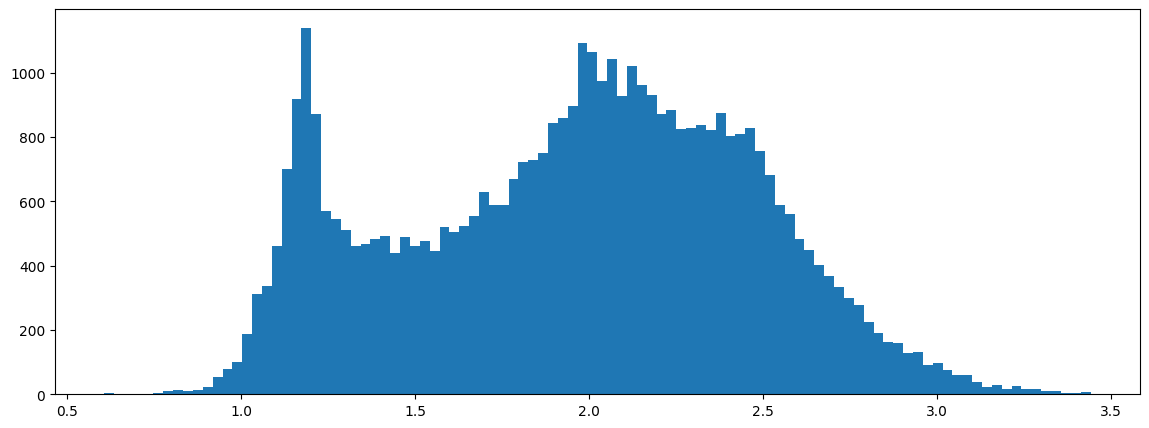

In [18]:
plt.hist(raps_df["pred_uct"], bins=100)

In [19]:
color_palette = {
    # regression
    "MVE": "#1f77b4",  # Blue
    "Quantile": "#ff7f0e",  # Orange
    "DKL": "#2ca02c",  # Green
    "Laplace": "#d62728",  # Red
    "DeepEnsemble": "#9467bd",  # Purple
    "MCDropout": "#8c564b",  # Brown
    "SWAG": "#e377c2",  # Pink
    "BNN VI ELBO ": "#7f7f7f",  # Gray
    "BNN VI ": "#4c4c4c",  # Dark Gray
    "DER": "#bcbd22",  # Lime
    "DUE": "#17becf",  # Teal
    "Deterministic": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARD": "#98df8a",
}

color_palette = {
    # Classification
    "DKL": "#2ca02c",  # Green
    "Laplace": "#d62728",  # Red
    "DeepEnsemble": "#9467bd",  # Purple
    "MCDropout": "#8c564b",  # Brown
    "SWAG": "#e377c2",  # Pink
    "BNN VI ELBO ": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUE": "#17becf",  # Teal
    "Deterministic": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARD": "#98df8a",
    "TempScaling": "#ff9896",  # Light Red
    "RAPS": "#c5b0d5",  # Light Purple
    }

In [20]:
import matplotlib.pyplot as plt


def plot_rmse(rmse_df, methods):
    # Filter the DataFrame for the given DS_SPLIT
    split_df = rmse_df[(rmse_df["split"] == f"preds_{DS_SPLIT}") & (rmse_df["uqmethod"].isin(methods))]

    # Get the unique pred_paths
    pred_paths = split_df["pred_path"].unique()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    handles_dict = {}

    # Plot a line for each pred_path
    for pred_path in pred_paths:
        path_df = split_df[split_df["pred_path"] == pred_path]
        method = path_df["uqmethod"].iloc[0]
        path_df = path_df.sort_values("threshold", ascending=False)
        if any(
            condition in pred_path for condition in ["Regression", "ConformalQR", "DER"]
        ):
            marker = "v-"
        else:
            marker = "o-"
        line, = plt.plot(path_df["threshold"], path_df["RMSE"], marker, label=method, color=color_palette[method])
        handles_dict[method] = line

    #remove Classification or Regression
    #Remove 'Classification' or 'Regression' from 'uqmethod'
    if "DeterministicClassification" in methods:
        path_df['uqmethod'] = path_df.loc[:,'uqmethod'].str.replace('Classification', '')
    else:
        path_df['uqmethod'] =  path_df.loc[:,'uqmethod'].str.replace('Regression', '') 
    
    path_df['uqmethod'] =  path_df.loc[:,'uqmethod'].str.replace('_', ' ') 
    
    # Add labels and title
    plt.xlim(max(path_df["threshold"]) + 0.01, min(path_df["threshold"]) - 0.01)
    start, end = plt.xlim()
    plt.xticks(
        np.arange(max(path_df["threshold"]), min(path_df["threshold"]), step=-0.1)
    )  # adjust the step size as needed
    plt.xlabel("Selective Quantile", fontsize=16)
    plt.ylabel("RMSE", fontsize=16)
    plt.title(f"RMSE for each threshold ({DS_SPLIT} split)", fontsize=20)

    plt.tick_params(axis='both', which='major', labelsize=14)

    # Create a list of handles in the order specified by your list
    handles = [handles_dict[method] for method in methods]
    
    # Add a legend
    plt.legend(handles=handles, bbox_to_anchor=(1.7, 0.5), loc="center right", fontsize=20, handleheight=1.5)

    # Show the plot
    plt.show()


# Call the function
# to_plot_df = rmse_df[
#     rmse_df["uqmethod"].isin(
#         # [
#         #     "BNN_VI_ELBO_Classification",
#         #     "BNN_VI_ELBO_Regression",
#         #     "MCDropoutClassification",
#         #     "MCDropoutRegression",
#         #     "DKLClassification",
#         #     "DKLRegression",
#         #     "DUEClassification",
#         #     "DUERegression",
#         #     "DeepEnsembleClassification",
#         #     "DeepEnsembleRegression",
#         #     "SWAGClassification",
#         #     "SWAGRegression",
#         #     "LaplaceClassification",
#         #     "LaplaceRegression",
#         #     # "RAPS"
#         # ]
#         CLASSIFICATION_METHODS
#         # REGRESSION_METHODS
#     )
# ]
plot_rmse(rmse_df, CLASSIFICATION_METHODS)

KeyError: 'SWAGClassification'

<Figure size 1000x600 with 0 Axes>

In [20]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"].groupby(group_cols, observed=False)[['mse', "mae"]].mean().apply(np.sqrt)
# drop nan values
category_df = category_df.dropna()

with pd.option_context("display.max_colwidth", None):
    display(category_df.head(50))

mse  \
uqmethod                   pred_path                                                                                                                                  storm_category              
BNN_VI_ELBO_Classification /p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_BNN_VI_ELBO_Classification_02-14-2024_14-02-22-295137/preds_test.csv       TD               8.719317   
                                                                                                                                                                      TS               9.250212   
                                                                                                                                                                      H1              16.705811   
                                                                                                                                                                      H2              25.258707   
                                                                                                                                                                      H3              33.448072   
                                                                                                                                                                      H4              42.236702   
                                                                                                                                                                      H5              65.216789   
BNN_VI_ELBO_Regression     /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_ELBO_Regression_02-23-2024_11-04-50-332445/preds_test.csv TD               6.478536   
                                                                                                                                                                      TS               8.360837   
                                                                                                                                                                      H1              13.405060   
                                                                                                                                                                      H2              13.377337   
                                                                                                                                                                      H3              17.175112   
                                                                                                                                                                      H4              15.703085   
                                                                                                                                                                      H5              16.580927   
BNN_VI_Regression          /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_Regression_02-26-2024_10-40-18-557918/preds_test.csv      TD               8.151825   
                                                                                                                                                                      TS               8.918031   
                                                                                                                                                                      H1              14.409426   
                                                                                                                                                                      H2              17.683122   
                                                                                                                                                                      H3              22.456768   
                                                                                             

# Compute metrics across categories

In [21]:
def compute_metrics(all_test_pred_df, quantile=0.95):
    group_cols = ["uqmethod", "pred_path", "storm_category"]

    category_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"].groupby(group_cols, observed=False)[['mse', "mae"]].mean()
    category_df['mse'] = category_df['mse'].apply(np.sqrt)

    category_df = category_df.dropna()
    category_df = category_df.reset_index()

    # rename mse to rmse column
    category_df = category_df.rename(columns={"mse": "rmse"})

    category_df["split"] = (
        category_df["pred_path"].str.rsplit("/", n=1).str[-1].str.rsplit(".").str[0]
    )

    corr_one = "mae"
    corr_two = "pred_uct"
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{DS_SPLIT}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]


    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df["storm_category"] = "all"

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )

    # Reset the index of the pivot table
    pivot_table_reset = pivot_table.reset_index()

    # Melt the pivot table
    final = pivot_table_reset.melt(id_vars='uqmethod')
    final.columns = ["uqmethod", "storm_category", "correlation"]
    category_df['uqmethod'] = category_df['uqmethod'].astype(str)
    final['uqmethod'] = final['uqmethod'].astype(str)
    category_df = category_df.merge(
        final, on=["uqmethod", "storm_category"], how="left"
    )

    # Compute empirical coverage for classification 
    # Filter the DataFrame for classification methods
    classification_df = all_test_pred_df[(all_test_pred_df["method_type"] == "Classification") & (all_test_pred_df["split"] == f"preds_{DS_SPLIT}")]

    # Check if 'target' is in 'pred_set' for each row
    classification_df['empirical_cov'] = classification_df.apply(lambda row: row['target'] in row['pred_set'], axis=1)

    # Compute empirical coverage for each storm category
    coverage_df = classification_df.groupby(['uqmethod', 'storm_category'])['empirical_cov'].mean().reset_index()

    # Merge the coverage_df into the category_df
    category_df = category_df.merge(coverage_df, on=["uqmethod", "storm_category"], how="left")


    # # prediction in interval
    # regression_df = all_test_pred_df[(all_test_pred_df["method_type"] == "Regression") & (all_test_pred_df["split"] == f"preds_{DS_SPLIT}")]
    # quantile = 0.9
    # prop_in_interval = (
    #     regression_df[regression_df["uqmethod"] != "DeterministicRegression"]
    #     .groupby(group_cols, observed=False)
    #     .apply(
    #         lambda x: uct.get_proportion_in_interval(
    #             x["pred"].values,
    #             x["pred_uct"].values,
    #             x["target"].values,
    #             quantile=quantile,
    #         )
    #     )
    #     .reset_index()
    # )
    # prop_in_interval.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

    # category_df = category_df.merge(
    #     prop_in_interval, on=["uqmethod", "storm_category"], how="left"
    # )

    # print(category_df)


    # columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
    # category_df = category_df.dropna(subset=columns_to_check)

    category_df["storm_category"] = category_df["storm_category"].astype("category")

    meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])

    category_df = category_df.merge(
        meta_df[["pred_path", "method_type"]], on="pred_path", how="left"
    )
    # 
        

    return category_df


category_df = compute_metrics(all_test_pred_df)
category_df

/tmp/ipykernel_3357/4156230866.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_3357/4156230866.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_3357/4156230866.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,uqmethod,pred_path,storm_category,rmse,mae,split,correlation,empirical_cov,method_type
0,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,TD,8.719317,6.511366,preds_test,0.774340,0.875407,Classification
1,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,TS,9.250212,7.388282,preds_test,0.506617,0.889396,Classification
2,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,H1,16.705811,14.009799,preds_test,0.477896,0.424713,Classification
3,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,H2,25.258707,22.296152,preds_test,0.403554,0.260974,Classification
4,BNN_VI_ELBO_Classification,/p/project/hai_uqmethodbox/experiment_output/t...,H3,33.448072,28.996188,preds_test,0.375445,0.193139,Classification
...,...,...,...,...,...,...,...,...,...
163,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,H1,16.584335,13.425908,preds_test,0.466555,0.483270,Classification
164,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,H2,20.207400,17.015935,preds_test,0.464052,0.502105,Classification
165,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,H3,22.731647,16.949174,preds_test,0.383180,0.442821,Classification
166,TempScaling,/p/project/hai_uqmethodbox/experiment_output/t...,H4,20.613300,14.350905,preds_test,0.485057,0.664537,Classification


In [22]:
category_df[category_df["method_type"] == "Classification"].tail(50)

,uqmethod,pred_path,storm_category,rmse,mae,split,correlation,empirical_cov,method_type
62,DUEClassification,/p/project/hai_uqmethodbox/experiment_output/t...,H5,15.563071,10.976190,preds_test,0.186905,0.591837,Classification
70,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,TD,14.603025,9.661762,preds_test,0.823841,0.734349,Classification
71,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,TS,18.358204,12.778235,preds_test,0.691135,0.698318,Classification
72,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,H1,21.295225,17.638623,preds_test,0.443323,0.384560,Classification
73,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,H2,21.797843,18.147625,preds_test,0.329401,0.416115,Classification
74,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,H3,25.659157,20.972681,preds_test,0.403457,0.361499,Classification
75,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,H4,30.247273,21.870607,preds_test,0.481232,0.428115,Classification
76,DeepEnsembleClassification,/p/project/hai_uqmethodbox/experiment_output/t...,H5,60.371004,51.452381,preds_test,0.629803,0.040816,Classification
84,DeterministicClassification,/p/project/hai_uqmethodbox/experiment_output/t...,TD,6.430966,4.605916,preds_test,0.739103,0.947841,Classification
85,DeterministicClassification,/p/project/hai_uqmethodbox/experiment_output/t...,TS,10.271377,8.240916,preds_test,0.457376,0.833908,Classification


In [23]:
all_test_pred_df[all_test_pred_df["uqmethod"]=="RAPS"].groupby("storm_category")["size"].mean()

/tmp/ipykernel_3357/1483336448.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_test_pred_df[all_test_pred_df["uqmethod"]=="RAPS"].groupby("storm_category")["size"].mean()


storm_category
TD     4.481643
TS     7.175524
H1    10.116213
H2    11.574601
H3    11.955150
H4    12.384028
H5    12.575646
Name: size, dtype: float64

/tmp/ipykernel_3357/4076682250.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['TD', 'TS', 'H1', 'H2', 'H3', ..., 'H1', 'H2', 'H3', 'H4', 'H5']
Length: 70
Categories (8, object): ['all' < 'TD' < 'TS' < 'H1' < 'H2' < 'H3' < 'H4' < 'H5']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  plot_cat_df.loc[:, "storm_category"] = pd.Categorical(


ValueError: The palette dictionary is missing keys: {'BNN_VI_ELBO_Classification'}

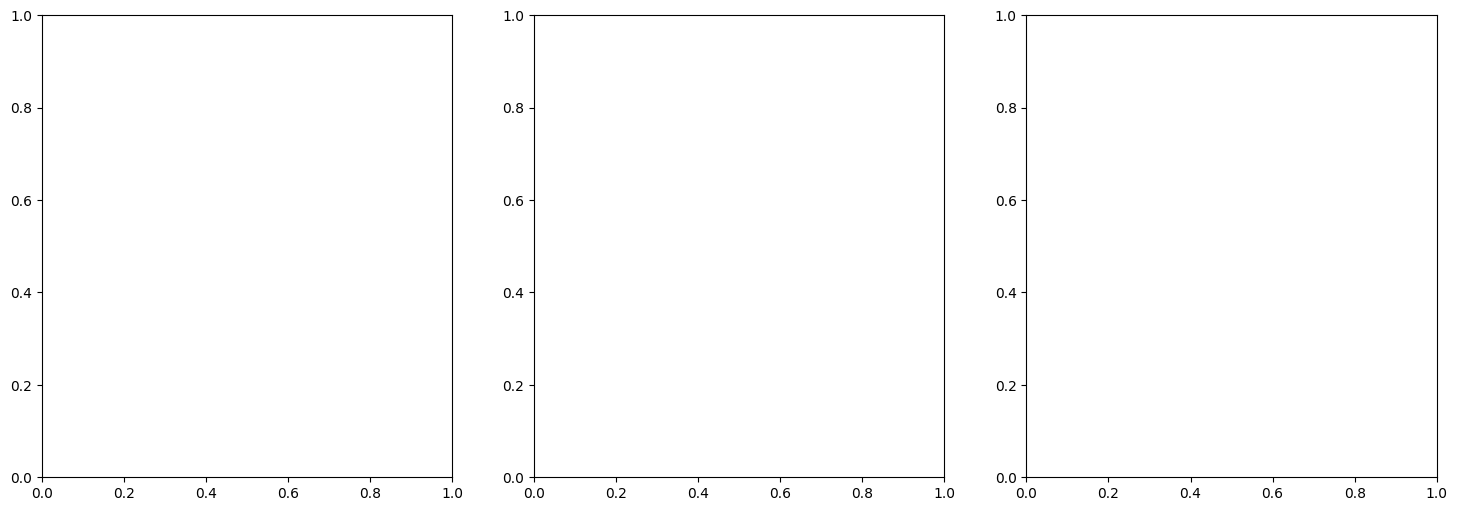

In [43]:
import math

def plot_metrics_by_category(category_df, split_type, method_type):
    plot_cat_df = category_df[(category_df["split"] == f"preds_{split_type}") & (category_df["method_type"].isin(method_type))]

    metrics = [
        "mae",
        # "proportion_in_0.9_interval",
        # "nll",
        # "sharpness",
        # "pred_uct",
        # "rmse",
        # "mace",
        "correlation",
    ]
    if "Classification" in method_type:
        metrics = metrics + ["empirical_cov"]
    else:
        metrics = metrics + ["proportion_in_0.9_interval"]

    # Calculate the number of rows and columns for the subplots
    num_metrics = len(metrics)
    num_cols = len(metrics)
    num_rows = math.ceil(num_metrics / num_cols)

    # Create the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to easily iterate over it

    plot_cat_df.loc[:, "storm_category"] = pd.Categorical(
        plot_cat_df["storm_category"].astype(str), categories=STORM_DISPLAY_ORDER, ordered=True
    )

    plot_cat_df = plot_cat_df[plot_cat_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_cat_df["storm_category"] = plot_cat_df[
        "storm_category"
    ].cat.remove_unused_categories()



    # Loop through the metrics
    for i, metric in enumerate(metrics):
        # Create the sns plot
        for method in plot_cat_df["uqmethod"].unique():
            sns.lineplot(
                x="storm_category",
                y=metric,
                hue="uqmethod",
                data=plot_cat_df[plot_cat_df["uqmethod"]==method],
                ax=axes[i],
                marker="o",
                palette=color_palette,
            )
        # sns.lineplot(
        #     x="storm_category",
        #     y=metric,
        #     hue="uqmethod",
        #     data=plot_cat_df[plot_cat_df["method_type"]=="Classification"],
        #     ax=axes[i],
        #     marker="o",
            
        # )
        # sns.lineplot(
        #     x="storm_category",
        #     y=metric,
        #     hue="uqmethod",
        #     data=plot_cat_df[plot_cat_df["method_type"]=="Regression"],
        #     ax=axes[i],
        #     marker="v",
        #     palette=color_palette,
        # )

        # Add title and increase the size
        axes[i].set_title(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)

        # Increase the size of the x and y labels
        axes[i].set_xlabel("Storm Category", fontsize=15)
        if "proportion" in metric:
            axes[i].set_ylabel("prop. interval", fontsize=15)
        elif metric == "correlation":
            axes[i].set_ylabel("corr(mae, pred uct)", fontsize=15)
            axes[i].set_title("Correlation with Predictive Uncertainty", fontsize=20)
        else:
            axes[i].set_ylabel(metric, fontsize=15)

        # Increase the size of the x and y ticks
        axes[i].tick_params(axis="both", which="major", labelsize=14)

    # Hide the remaining unused subplots
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axes[j])

    # set the linewidths to the copies
    handles, labels = axes[0].get_legend_handles_labels()
    # handles = [hand for method in order]
    [ha.set_linewidth(10) for ha in handles]

    # Replace the labels using the VAR_TO_PLOT_LABEL dictionary
    #labels = [
    #     VAR_TO_PLOT_LABEL[label] if label in VAR_TO_PLOT_LABEL else label
    #     for label in labels
    # ]

    # Increase the size of the legend labels
    fig.legend(
        handles,
        labels,
        loc="center right",
        bbox_to_anchor=(1.3, 0.5),
        fontsize=20,
        handleheight=1.5,
    )

    # Remove individual legends
    for ax in axes.flat:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

    print(labels)
    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


# Call the function with 'train' or 'val' as the argument
plot_metrics_by_category(category_df, DS_SPLIT, ["Classification"])

In [25]:
with pd.option_context("display.max_colwidth", None):
    display(all_test_pred_df[all_test_pred_df["split"]== f"preds_{DS_SPLIT}"].groupby("uqmethod").storm_category.value_counts().head(50))

uqmethod                    storm_category
BNN_VI_ELBO_Classification  TS                18851
                            TD                16277
                            H1                 4184
                            H2                 1663
                            H3                 1574
                            H4                  939
                            H5                  147
BNN_VI_ELBO_Regression      TS                18662
                            TD                16670
                            H1                 4071
                            H3                 1574
                            H2                 1572
                            H4                  939
                            H5                  147
BNN_VI_Regression           TS                18662
                            TD                16670
                            H1                 4071
                            H3                 1574
                     

## Selective Prediction across Categories

In [26]:
def compute_improvement(all_test_pred_df):
    improvement_df = pd.DataFrame()

    for method in tqdm(all_test_pred_df['uqmethod'].unique()):
        method_df = all_test_pred_df[(all_test_pred_df['uqmethod'] == method) & (all_test_pred_df["split"]== f"preds_{DS_SPLIT}")]
        for category in all_test_pred_df['storm_category'].unique().tolist() + ['overall']:
            # Filter the DataFrame for the current method and category
            if category == 'overall':
                df = method_df.reset_index(drop=True)
            else:
                df = method_df[method_df['storm_category'] == category].reset_index(drop=True)
                if len(df) == 0:
                    continue

            method_type = df.loc[0, 'method_type']

            # Compute the initial metric (e.g., RMSE)
            initial_metric = np.sqrt(df['mse'].mean())

            # Apply selective prediction
            quantile = SELECTIVE_PRED_DICT[os.path.dirname(df.loc[0, "pred_path"])][0.8]
            total_rows = len(df)
            df = df[df['pred_uct'] <= quantile]
            remaining_rows = len(df)

            # Compute the metric after applying selective prediction
            selective_metric = np.sqrt(df['mse'].mean())

            # Compute the absolute improvement
            improvement = initial_metric - selective_metric

            # Compute the coverage
            coverage = remaining_rows / total_rows

            # Append the result to the improvement_df DataFrame
            result_df = pd.DataFrame({
                'uqmethod': [method],
                'storm_category': [category],
                'improvement': [improvement],
                "before": [initial_metric],
                "after": [selective_metric],
                'coverage': [coverage],  # Add the coverage value
                'method_type': [method_type],  # Add the method_type value from d
                "split": [f"preds_{DS_SPLIT}"]
            })
            improvement_df = pd.concat([improvement_df, result_df], ignore_index=True)
    return improvement_df

improvement_df = compute_improvement(all_test_pred_df)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:11<00:00,  2.00it/s]


In [27]:
improvement_df

,uqmethod,storm_category,improvement,before,after,coverage,method_type,split
0,SWAGClassification,TD,0.661337,7.748755,7.087418,0.982675,Classification,preds_test
1,SWAGClassification,TS,1.064849,9.941190,8.876341,0.838046,Classification,preds_test
2,SWAGClassification,H3,0.362753,17.064410,16.701658,0.383736,Classification,preds_test
3,SWAGClassification,H1,0.307279,13.975344,13.668065,0.528681,Classification,preds_test
4,SWAGClassification,H2,1.594780,15.094167,13.499387,0.435959,Classification,preds_test
...,...,...,...,...,...,...,...,...
187,MVERegression,H1,-2.299675,13.800800,16.100475,0.463768,Regression,preds_test
188,MVERegression,H2,0.689370,14.503534,13.814164,0.430662,Regression,preds_test
189,MVERegression,H4,3.275071,14.843347,11.568276,0.486688,Regression,preds_test
190,MVERegression,H5,2.932034,18.174561,15.242527,0.653061,Regression,preds_test


/tmp/ipykernel_3357/2484813581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['uqmethod'] = df['uqmethod'].str.replace('Classification', '').str.replace('Regression', '')
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version

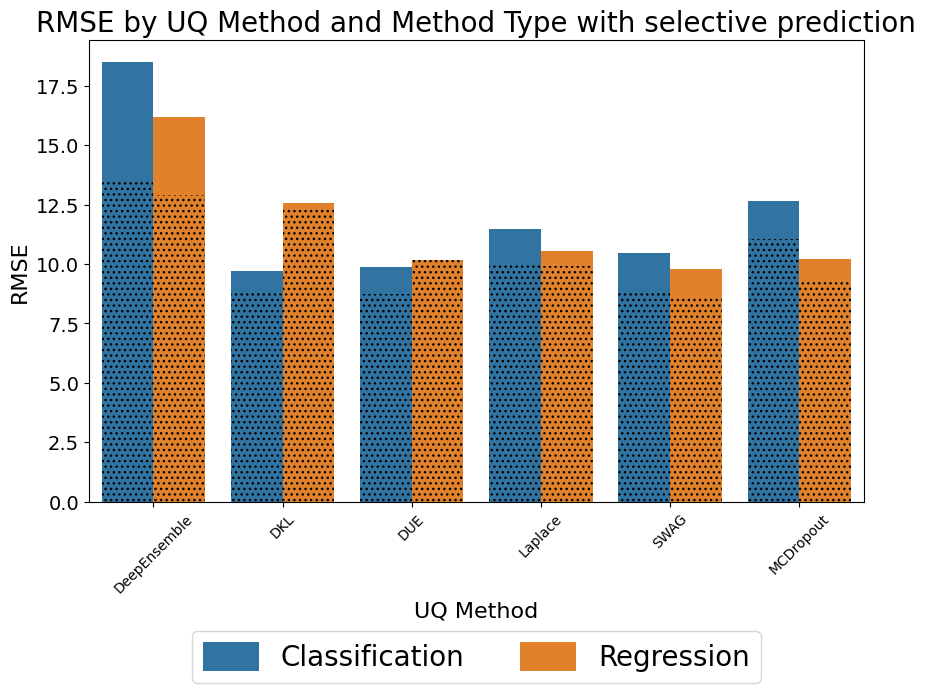

In [28]:
def plot_grouped_improvement(improvement_df):
    # Filter the DataFrame for the specified uqmethods
    df = improvement_df[(improvement_df['uqmethod'].str.contains('Classification')) | 
                        (improvement_df['uqmethod'].str.contains('Regression'))]

    # Remove 'Classification' or 'Regression' from 'uqmethod'
    df['uqmethod'] = df['uqmethod'].str.replace('Classification', '').str.replace('Regression', '')

    # Exclude specified uqmethods
    df = df[~df['uqmethod'].isin(['MVE', 'CARD', 'Quantile', 'BNN_VI_ELBO_', 'BNN_VI_', "Deterministic"])]

    # Filter for 'overall' category
    df = df[df['storm_category'] == 'overall']

    # Specify the order of appearance on the x-axis
    order = ["DeepEnsemble", "DKL", "DUE", "Laplace", "SWAG", "MCDropout"]  # Replace with your actual method names

    # Create a grouped bar plot for 'before'
    fig, ax = plt.subplots(1, figsize=(10, 6))
    bar1 = sns.barplot(data=df, x='uqmethod', y='before', hue='method_type', order=order)

    # Add a dotted bar for 'after'
    bar2 = sns.barplot(data=df, x='uqmethod', y='after', hue='method_type',
                hatch="...", order=order)

    # Set the plot title and labels
    ax.set_title('RMSE by UQ Method and Method Type with selective prediction', size=20)
    ax.set_xlabel('UQ Method', size=16)
    ax.set_ylabel('RMSE', size=16)

    ax.yaxis.set_tick_params(labelsize=14)

    plt.xticks(rotation=45)

    # Create a custom legend
    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(legend_labels[:len(df.method_type.unique())], df.method_type.unique(),
            loc="upper center",
            bbox_to_anchor=(0.5, -0.25),
            fontsize=20,
            handleheight=1.2,
            ncol=len(df.method_type.unique())
        )

    # Show the plot
    plt.show()

plot_grouped_improvement(improvement_df)

In [29]:
color_palette = {
    # Classification
    "DKL": "#2ca02c",  # Green
    "Laplace": "#d62728",  # Red
    "DeepEnsemble": "#9467bd",  # Purple
    "MCDropout": "#8c564b",  # Brown
    "SWAG": "#e377c2",  # Pink
    "BNN VI ELBO ": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUE": "#17becf",  # Teal
    "Deterministic": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARD": "#98df8a",
    "TempScaling": "#ff9896",  # Light Red
    "RAPS": "#c5b0d5",  # Light Purple
    }

color_palette = {
    # regression
    "MVE": "#1f77b4",  # Blue
    "Quantile": "#ff7f0e",  # Orange
    "DKL": "#2ca02c",  # Green
    "Laplace": "#d62728",  # Red
    "DeepEnsemble": "#9467bd",  # Purple
    "MCDropout": "#8c564b",  # Brown
    "SWAG": "#e377c2",  # Pink
    "BNN VI ELBO ": "#7f7f7f",  # Gray
    "BNN VI ": "#4c4c4c",  # Dark Gray
    "DER": "#bcbd22",  # Lime
    "DUE": "#17becf",  # Teal
    "Deterministic": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARD": "#98df8a",
}

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

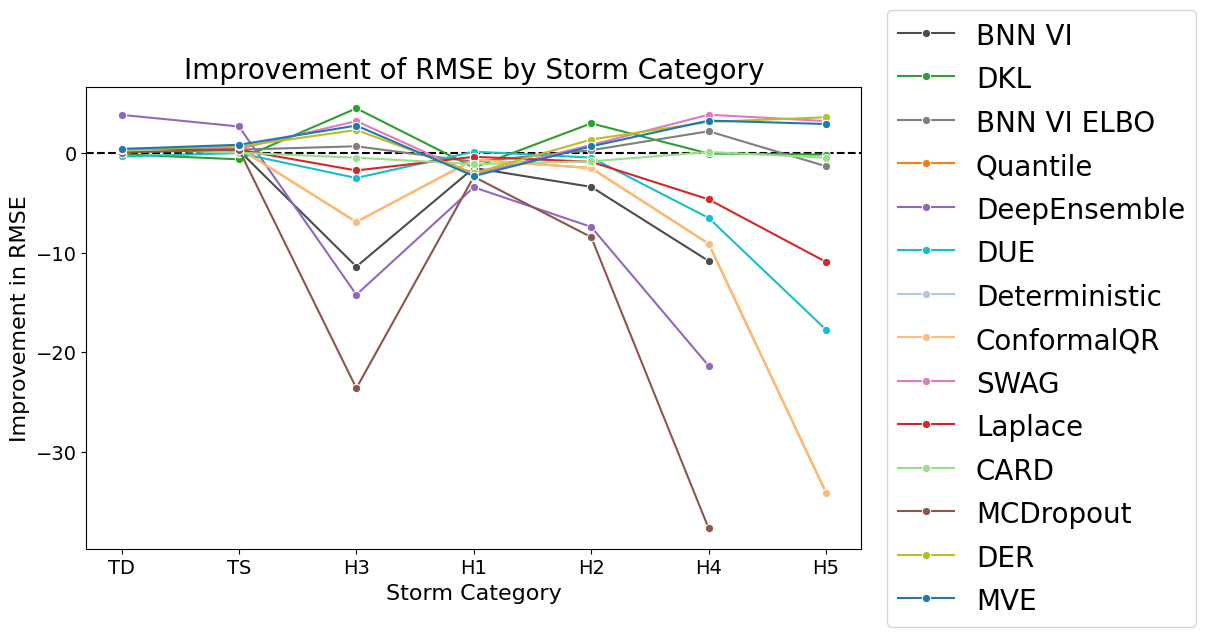

In [30]:

    
def plot_improvement(improvement_df, uqmethods):
    # Filter the DataFrame for the specified uqmethods
    df = improvement_df[(improvement_df['uqmethod'].isin(uqmethods)) & (improvement_df['storm_category'] != 'overall')]
    #df = df['uqmethod'] 
    df = df.copy()

    #Remove 'Classification' or 'Regression' from 'uqmethod'
    if "DeterministicClassification" in uqmethods:
        df['uqmethod'] = df.loc[:,'uqmethod'].str.replace('Classification', '')
    else:
        df['uqmethod'] =  df.loc[:,'uqmethod'].str.replace('Regression', '') 
    
    df['uqmethod'] =  df.loc[:,'uqmethod'].str.replace('_', ' ') 

    # Create a line plot
    fig, ax = plt.subplots(1, figsize=(10, 6))
    # Add a horizontal line at y=0
    ax.axhline(0, color='black', linestyle='--')
    # ax.axhspan(0, max(df['improvement']), facecolor='green', alpha=0.1)
    # ax.axhspan(min(df['improvement']), 0, facecolor='red', alpha=0.1)
    sns.lineplot(data=df, x='storm_category', y='improvement', hue='uqmethod', marker='o', palette=color_palette)

    # Set the plot title and labels
    # Set the plot title and labels
    ax.set_title('Improvement of RMSE by Storm Category', size=20)
    ax.set_xlabel('Storm Category', size=16)
    ax.set_ylabel('Improvement in RMSE', size=16)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)


    plt.legend(
            loc="center right",
            bbox_to_anchor=(1.45, 0.5),
            fontsize=20,
            handleheight=1.2,
        )

    # Show the plot
    plt.show()


plot_improvement(improvement_df, REGRESSION_METHODS)

In [31]:
improvement_df

,uqmethod,storm_category,improvement,before,after,coverage,method_type,split
0,SWAGClassification,TD,0.661337,7.748755,7.087418,0.982675,Classification,preds_test
1,SWAGClassification,TS,1.064849,9.941190,8.876341,0.838046,Classification,preds_test
2,SWAGClassification,H3,0.362753,17.064410,16.701658,0.383736,Classification,preds_test
3,SWAGClassification,H1,0.307279,13.975344,13.668065,0.528681,Classification,preds_test
4,SWAGClassification,H2,1.594780,15.094167,13.499387,0.435959,Classification,preds_test
...,...,...,...,...,...,...,...,...
187,MVERegression,H1,-2.299675,13.800800,16.100475,0.463768,Regression,preds_test
188,MVERegression,H2,0.689370,14.503534,13.814164,0.430662,Regression,preds_test
189,MVERegression,H4,3.275071,14.843347,11.568276,0.486688,Regression,preds_test
190,MVERegression,H5,2.932034,18.174561,15.242527,0.653061,Regression,preds_test


In [32]:
improvement_df[improvement_df["uqmethod"]=="SWAGRegression"]

,uqmethod,storm_category,improvement,before,after,coverage,method_type,split
144,SWAGRegression,TD,0.424296,6.940312,6.516016,0.985603,Regression,preds_test
145,SWAGRegression,TS,0.451001,9.050768,8.599767,0.777623,Regression,preds_test
146,SWAGRegression,H3,3.226350,16.306905,13.080555,0.476493,Regression,preds_test
147,SWAGRegression,H1,-2.114068,13.804647,15.918715,0.456399,Regression,preds_test
148,SWAGRegression,H2,0.836410,14.761012,13.924603,0.430662,Regression,preds_test
149,SWAGRegression,H4,3.866608,16.083288,12.216680,0.527157,Regression,preds_test
150,SWAGRegression,H5,3.227322,20.497210,17.269888,0.653061,Regression,preds_test
151,SWAGRegression,overall,1.131844,9.779521,8.647677,0.797937,Regression,preds_test


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


5 5.025021354893159


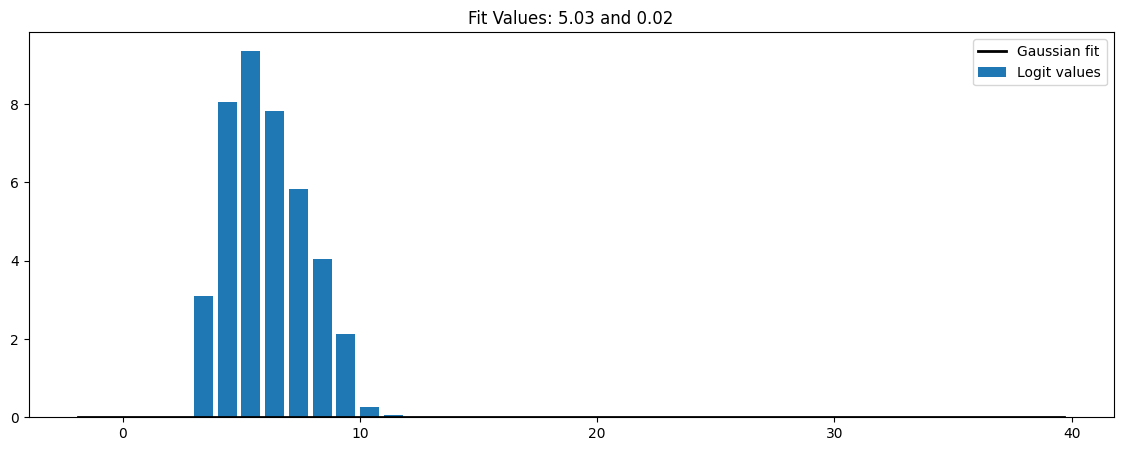

In [33]:
logit_cols = [col for col in all_test_pred_df.columns if col.startswith("logit_")]

# Compute softmax values for each logit
# exp_logits = np.exp(all_test_pred_df[logit_cols].values)
# softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
logits = all_test_pred_df[logit_cols].values

logits_softplus = np.log1p(np.exp(logits))

bin_intervals = np.diff(WIND_SPEED_BINS) / 2
bin_midpoints = (np.append(bin_intervals, bin_intervals[-1])) + WIND_SPEED_BINS

# Select the first row of softmax values
softplus_row = logits_softplus[20, :]

from scipy.optimize import curve_fit


# Define a Gaussian function
def gaussian(x, mu, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)


# Fit a Gaussian to the softmax values
popt, pcov = curve_fit(gaussian, np.arange(len(softplus_row)), softplus_row, p0=[0, 1])

# Extract the fitted parameters
mu, std = popt

# Plot the softmax values as a bar plot
plt.bar(np.arange(len(softplus_row)), softplus_row, align="edge", label="Logit values")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gaussian(x, mu, std)
plt.plot(x, p, "k", linewidth=2, label="Gaussian fit")

# Add a title and legend
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.legend()

print(np.argmax(softplus_row), mu)
# Display the plot
plt.show()

,pred,pred_uct,target,storm_id,index,wind_speed,logit_0,logit_1,logit_2,logit_3,...,argmax_reg,softmax_weighted_reg,top_5_logits,method_type,TARGET_MEAN,TARGET_STD,point_pred,mse,mae,storm_category
120653,5.0,1.410128,6.0,acd,0.0,33.0,0.000013,0.000013,0.000013,0.006990,...,27.5,30.649273,"{4, 5, 6, 7, 8}",Classification,NaN,NaN,27.5,30.25,5.5,TS
120654,5.0,1.430865,6.0,acd,1.0,33.0,0.000010,0.000010,0.000010,0.005167,...,27.5,31.278625,"{4, 5, 6, 7, 8}",Classification,NaN,NaN,27.5,30.25,5.5,TS
120655,5.0,1.380496,6.0,acd,2.0,32.0,0.000020,0.000019,0.000020,0.010091,...,27.5,29.844861,"{4, 5, 6, 7, 8}",Classification,NaN,NaN,27.5,20.25,4.5,TD
120656,5.0,1.329263,6.0,acd,3.0,32.0,0.000064,0.000064,0.000064,0.025188,...,27.5,27.907752,"{3, 4, 5, 6, 7}",Classification,NaN,NaN,27.5,20.25,4.5,TD
120657,5.0,1.303885,6.0,acd,4.0,31.0,0.000119,0.000121,0.000121,0.038682,...,27.5,26.961955,"{3, 4, 5, 6, 7}",Classification,NaN,NaN,27.5,12.25,3.5,TD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164283,4.0,1.387067,4.0,zza,43630.0,20.0,0.002346,0.002387,0.002384,0.137658,...,22.5,27.284547,"{3, 4, 5, 6, 7}",Classification,NaN,NaN,22.5,6.25,2.5,TD
164284,4.0,1.455369,4.0,zza,43631.0,20.0,0.003210,0.003258,0.003251,0.147969,...,22.5,28.594969,"{3, 4, 5, 6, 7}",Classification,NaN,NaN,22.5,6.25,2.5,TD
164285,4.0,1.612432,4.0,zza,43632.0,20.0,0.005126,0.005193,0.005171,0.160627,...,22.5,31.866282,"{3, 4, 5, 6, 7}",Classification,NaN,NaN,22.5,6.25,2.5,TD
164286,4.0,1.748967,4.0,zza,43633.0,20.0,0.006802,0.006850,0.006820,0.164057,...,22.5,34.881809,"{3, 4, 5, 6, 7}",Classification,NaN,NaN,22.5,6.25,2.5,TD


count    43635.000000
mean         1.899196
std          0.401268
min          1.253761
25%          1.513440
50%          1.923287
75%          2.292299
max          3.402336
Name: pred_uct, dtype: float64


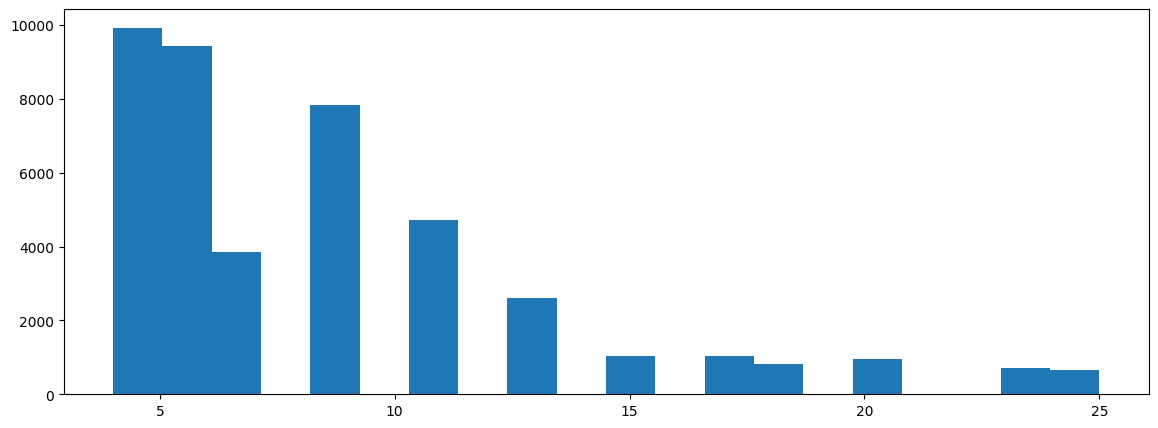

In [34]:
with pd.option_context("display.max_colwidth", None):
    df = all_test_pred_df[
        (all_test_pred_df["uqmethod"] == "DKLClassification")
        & (all_test_pred_df["split"] == "preds_test")
    ]
    display(df)
    fig, ax = plt.subplots(1)
    ax.hist(df["pred"], bins=20, label="target")
    print(df["pred_uct"].describe())
    plt.show()

In [35]:
# from uct_toolbox.metrics import crps_ensemble, log_score, miscalibration_area, ece
from netcal.metrics import ECE
import uncertainty_toolbox.metrics_calibration as uct_cal
import uncertainty_toolbox.metrics_scoring_rule as uct_score
from scipy.special import softmax

def compute_metrics(df, pred_col: str):
    group_cols = ["uqmethod", "split", "pred_path"]

    # compute_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"]
        
    df["mse"] = (df[pred_col] - df["wind_speed"]) ** 2
    df["mae"] = np.abs(df[pred_col] - df["wind_speed"])
    
    def apply_crps(group):
        if 'Regression' == group['method_type'].iloc[0]:
            return uct_score.crps_gaussian(
                group[pred_col].values, group["pred_uct"].values, group["wind_speed"].values
            )
        else:
            return np.nan

    # Apply the function to the grouped dataframe for CRPS
    result_crps = (
        df[df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_crps)
        .reset_index()
    )

    result_crps.rename(columns={0: "crps"}, inplace=True)

    def apply_nll(group):
        if 'Regression' == group['method_type'].iloc[0]:
            return uct_score.nll_gaussian(
                group[pred_col].values, group["pred_uct"].values, group["wind_speed"].values
            )
        else:
            return np.nan

    # Apply the function to the grouped dataframe for CRPS
    result_nll = (
        df[df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_nll)
        .reset_index()
    )

    result_nll.rename(columns={0: "nll"}, inplace=True)

    def apply_mace(group):
        if 'Regression' == group['method_type'].iloc[0]:
            return uct_cal.mean_absolute_calibration_error(
                group[pred_col].values, group["pred_uct"].values, group["wind_speed"].values
            )
        else:
            return np.nan

    # Apply the function to the grouped dataframe for MACE
    result_mace = (
        df[df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_mace)
        .reset_index()
    )

    # Rename the result column for MACE
    result_mace.rename(columns={0: "mace"}, inplace=True)


    def apply_ece(group):
        if "Classification" == group["method_type"].iloc[0]:
            logits = group.filter(regex='logit_').values
            softmax_logits = softmax(logits, axis=1)
            return ECE(bins=15).measure(softmax_logits, group["target"].values[:,None])
        else:
            np.nan


    result_ece = (
        df
        .groupby(group_cols, observed=False)
        .apply(apply_ece)
        .reset_index()
    )

    result_ece.rename(columns={0: "ece"}, inplace=True)
    
    metric_df = (
        df.groupby(["uqmethod", "split", "pred_path"])
        .agg({"mse": "mean", "mae": "mean"})
        .reset_index()
    )
    metric_df["rmse"] = metric_df["mse"].apply(np.sqrt)

    method_type_df = df.groupby(group_cols)['method_type'].first().reset_index()
    metric_df = metric_df.merge(method_type_df, on=group_cols, how='left')

    # Merge the result dataframes back to metric_df
    metric_df = metric_df.merge(result_crps, on=group_cols, how='left')
    metric_df = metric_df.merge(result_nll, on=group_cols, how='left')
    metric_df = metric_df.merge(result_mace, on=group_cols, how='left')
    metric_df = metric_df.merge(result_ece, on=group_cols, how='left')
    
    return metric_df

computed_metrics_df = compute_metrics(all_test_pred_df, "point_pred")

/tmp/ipykernel_3357/1855927635.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_crps)
/tmp/ipykernel_3357/1855927635.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_nll)
/tmp/ipykernel_3357/1855927635.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will b

In [36]:
computed_metrics_df

,uqmethod,split,pred_path,mse,mae,rmse,method_type,crps,nll,mace,ece
0,BNN_VI_ELBO_Classification,preds_test,/p/project/hai_uqmethodbox/experiment_output/t...,209.475759,9.760594,14.473277,Classification,NaN,NaN,NaN,0.091489
1,BNN_VI_ELBO_Classification,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,184.348956,8.843934,13.577517,Classification,NaN,NaN,NaN,0.042372
2,BNN_VI_ELBO_Classification,preds_val,/p/project/hai_uqmethodbox/experiment_output/t...,342.655806,11.704257,18.510964,Classification,NaN,NaN,NaN,0.075980
3,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,86.016385,6.744963,9.274502,Regression,6.275765,52.603906,0.413778,NaN
4,BNN_VI_ELBO_Regression,preds_train,/p/project/hai_uqmethodbox/experiment_output/m...,5.780140,1.769174,2.404192,Regression,1.424309,4.356502,0.242259,NaN
...,...,...,...,...,...,...,...,...,...,...,...
67,SWAGRegression,preds_train,/p/project/hai_uqmethodbox/experiment_output/m...,57.606444,5.639105,7.589891,Regression,4.582270,3.630878,0.204500,NaN
68,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,108.612072,7.539950,10.421712,Regression,5.694398,3.767161,0.132625,NaN
69,TempScaling,preds_test,/p/project/hai_uqmethodbox/experiment_output/t...,132.006067,8.186674,11.489389,Classification,NaN,NaN,NaN,0.019170
70,TempScaling,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,117.532388,7.850980,10.841236,Classification,NaN,NaN,NaN,0.025128


In [37]:
DS_SPLIT

'test'

In [38]:
with pd.option_context("display.max_colwidth", None):
    display(computed_metrics_df[computed_metrics_df["uqmethod"]=="DKLClassification"])
    display(computed_metrics_df[computed_metrics_df["uqmethod"]=="DKLRegression"])

,uqmethod,split,pred_path,mse,mae,rmse,method_type,crps,nll,mace,ece
18,DKLClassification,preds_test,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_test.csv,94.215532,7.194740,9.706469,Classification,NaN,NaN,NaN,0.259694
19,DKLClassification,preds_train,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_train.csv,74.851725,6.531305,8.651689,Classification,NaN,NaN,NaN,0.286090
20,DKLClassification,preds_val,/p/project/hai_uqmethodbox/experiment_output/test_class/cyclone_DKLClassification_03-05-2024_11-39-38-889541/preds_val.csv,111.455031,7.770440,10.557227,Classification,NaN,NaN,NaN,0.246017


,uqmethod,split,pred_path,mse,mae,rmse,method_type,crps,nll,mace,ece
21,DKLRegression,preds_test,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,158.412660,9.340257,12.586209,Regression,6.840202,3.948189,0.055761,NaN
22,DKLRegression,preds_train,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,128.961526,8.623980,11.356123,Regression,6.293967,3.861324,0.072472,NaN
23,DKLRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_val.csv,161.261564,9.342685,12.698880,Regression,6.848777,3.949773,0.056251,NaN


## Tables

In [39]:
improvement_df

,uqmethod,storm_category,improvement,before,after,coverage,method_type,split
0,SWAGClassification,TD,0.661337,7.748755,7.087418,0.982675,Classification,preds_test
1,SWAGClassification,TS,1.064849,9.941190,8.876341,0.838046,Classification,preds_test
2,SWAGClassification,H3,0.362753,17.064410,16.701658,0.383736,Classification,preds_test
3,SWAGClassification,H1,0.307279,13.975344,13.668065,0.528681,Classification,preds_test
4,SWAGClassification,H2,1.594780,15.094167,13.499387,0.435959,Classification,preds_test
...,...,...,...,...,...,...,...,...
187,MVERegression,H1,-2.299675,13.800800,16.100475,0.463768,Regression,preds_test
188,MVERegression,H2,0.689370,14.503534,13.814164,0.430662,Regression,preds_test
189,MVERegression,H4,3.275071,14.843347,11.568276,0.486688,Regression,preds_test
190,MVERegression,H5,2.932034,18.174561,15.242527,0.653061,Regression,preds_test


In [40]:
computed_metrics_df

,uqmethod,split,pred_path,mse,mae,rmse,method_type,crps,nll,mace,ece
0,BNN_VI_ELBO_Classification,preds_test,/p/project/hai_uqmethodbox/experiment_output/t...,209.475759,9.760594,14.473277,Classification,NaN,NaN,NaN,0.091489
1,BNN_VI_ELBO_Classification,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,184.348956,8.843934,13.577517,Classification,NaN,NaN,NaN,0.042372
2,BNN_VI_ELBO_Classification,preds_val,/p/project/hai_uqmethodbox/experiment_output/t...,342.655806,11.704257,18.510964,Classification,NaN,NaN,NaN,0.075980
3,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,86.016385,6.744963,9.274502,Regression,6.275765,52.603906,0.413778,NaN
4,BNN_VI_ELBO_Regression,preds_train,/p/project/hai_uqmethodbox/experiment_output/m...,5.780140,1.769174,2.404192,Regression,1.424309,4.356502,0.242259,NaN
...,...,...,...,...,...,...,...,...,...,...,...
67,SWAGRegression,preds_train,/p/project/hai_uqmethodbox/experiment_output/m...,57.606444,5.639105,7.589891,Regression,4.582270,3.630878,0.204500,NaN
68,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,108.612072,7.539950,10.421712,Regression,5.694398,3.767161,0.132625,NaN
69,TempScaling,preds_test,/p/project/hai_uqmethodbox/experiment_output/t...,132.006067,8.186674,11.489389,Classification,NaN,NaN,NaN,0.019170
70,TempScaling,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,117.532388,7.850980,10.841236,Classification,NaN,NaN,NaN,0.025128


In [41]:
def generate_latex_table(improvement_df, computed_metrics_df, split_type, method_type):
    if method_type == "Regression":
        category_columns = ["rmse", "improvement", "coverage", "crps", "nll", "mace"]
    else:
        category_columns = ["rmse", "improvement", "coverage", "ece"]
    # table_columns = ["default", "diff"]
    # columns = pd.MultiIndex.from_product(
    #     [["default", "diff"]]
    # )

    table_uq_df = improvement_df[(improvement_df["split"] == f"preds_{split_type}") & (improvement_df["storm_category"] == "overall") & (improvement_df["method_type"]==method_type)]
    table_metric_df = computed_metrics_df[(computed_metrics_df["split"] == f"preds_{split_type}") & (computed_metrics_df["method_type"]==method_type)]



    # Merge the two dataframes on the common columns
    combined_df = pd.merge(table_uq_df, table_metric_df, on=['uqmethod', "split", 'method_type'])

    combined_df["uqmethod"] = pd.Categorical(
        combined_df["uqmethod"], categories=UQ_METHOD_DISPLAY_ORDER[method_type], ordered=True
    )

    # Ensure the DataFrame only contains the specified category columns
    combined_df = combined_df[["uqmethod"] + category_columns]

    # Round the values to 2 decimal places
    combined_df = combined_df.round(2)

    combined_df = combined_df.sort_values("uqmethod")

    unique_uqmethods = combined_df['uqmethod'].unique()

    # Add a new column for the groups
    combined_df["group"] = combined_df["uqmethod"].apply(
        lambda x: next((k for k, v in UQ_METHOD_GROUPS.items() if x in v), "None")
    )

    # Move the group column to the front
    combined_df = combined_df[
        ["group"] + [col for col in combined_df.columns if col != "group"]
    ]

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    combined_df["uqmethod"] = combined_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    print(combined_df)
    latex_table = as_latex_output(combined_df, category_columns)
    return latex_table


def as_latex_output(combined_df, category_columns):
    """Format latex output"""
    combined_df = combined_df.round(4)
    max_values = combined_df.max()
    min_values = combined_df.min()

    # Replace the group names with the \multirow command
    for group in UQ_METHOD_GROUPS.keys():
        num_rows = len(combined_df[combined_df["group"] == group])
        group_indices = combined_df[combined_df["group"] == group].index
        if len(group_indices) > 0:
            first_index = group_indices[0]
            combined_df.at[first_index, "group"] = (
                r"\multirow{" + str(num_rows) + "}{*}{" + group + "}"
            )
            for index in group_indices[1:]:
                combined_df.at[index, "group"] = ""

    # convert to latex
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.2f")

    # bold face column values
    min_cols = ["rmse", "crps", "nll", "mace", "ece"]
    max_cols = ["improvement", "Coverage"]
    for column in max_values.index:
        if column in max_cols:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        elif column in min_cols:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        else:
            continue

    # Replace the category_columns values using the VAR_TO_PLOT_LABEL dictionary
    for column in category_columns:
        latex_output = latex_output.replace(
            column, VAR_TO_PLOT_LABEL[column] if column in VAR_TO_PLOT_LABEL else column
        )

    # other formatting
    # latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\\multirow", "\\midrule\n\\multirow")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("RMSE", "RMSE $\downarrow$")
    latex_output = latex_output.replace(
        "diff RMSE $\downarrow$", r"RMSE $\Delta$ $\uparrow$"
    )
    latex_output = latex_output.replace("improvement", r"RMSE $\Delta$ $\uparrow$")
    latex_output = latex_output.replace("NLL", "NLL $\downarrow$")
    latex_output = latex_output.replace("MACE", "MACE $\downarrow$")
    latex_output = latex_output.replace("Coverage", r"Coverage $\uparrow$")
    latex_output = latex_output.replace("CRPS", "CRPS $\downarrow$")
    latex_output = latex_output.replace("ece", "ECE $\downarrow$")

    latex_output = latex_output.replace("group", "UQ group")
    latex_output = latex_output.replace("uqmethod", "Method")

    return latex_output


latex_table = generate_latex_table(improvement_df, computed_metrics_df, DS_SPLIT, "Regression")
print(latex_table)

            group       uqmethod   rmse  improvement  coverage   crps    nll  \
6            None  Deterministic  10.50          NaN      0.00    NaN    NaN   
13  Deterministic            MVE   9.95         1.15      0.80   5.31   3.64   
12  Deterministic            DER  10.14         1.17      0.81  10.07   4.60   
3        Quantile       Quantile  10.95         1.05      0.84   5.82   3.73   
7        Quantile   Conformal QR  10.95         1.05      0.84   5.98   3.79   
11       Bayesian     MC Dropout  10.23         0.87      0.85   5.78   3.81   
8        Bayesian           SWAG   9.78         1.13      0.80   5.40   3.71   
9        Bayesian        Laplace  10.53         0.60      0.83   7.96   4.31   
0        Bayesian         BNN VI  11.20         1.45      0.84   5.83   3.74   
2        Bayesian    BNN VI ELBO   9.27         0.85      0.73   6.28  52.60   
1        Bayesian            DKL  12.59         0.21      0.78   6.84   3.95   
5        Bayesian            DUE   9.95 

        pred  pred_uct  target storm_id   index  wind_speed   logit_0  \
460988  13.0  1.993554    15.0      fmv  9381.0        78.0  0.000002   

         logit_1   logit_2       logit_3  ...  argmax_reg  \
460988  0.000002  0.000002  2.200000e-08  ...        67.5   

        softmax_weighted_reg          top_5_logits     method_type  \
460988             73.243586  {12, 13, 14, 15, 16}  Classification   

        TARGET_MEAN  TARGET_STD  point_pred     mse   mae  storm_category  
460988          NaN         NaN        67.5  110.25  10.5              H1  

[1 rows x 66 columns]
9381.0


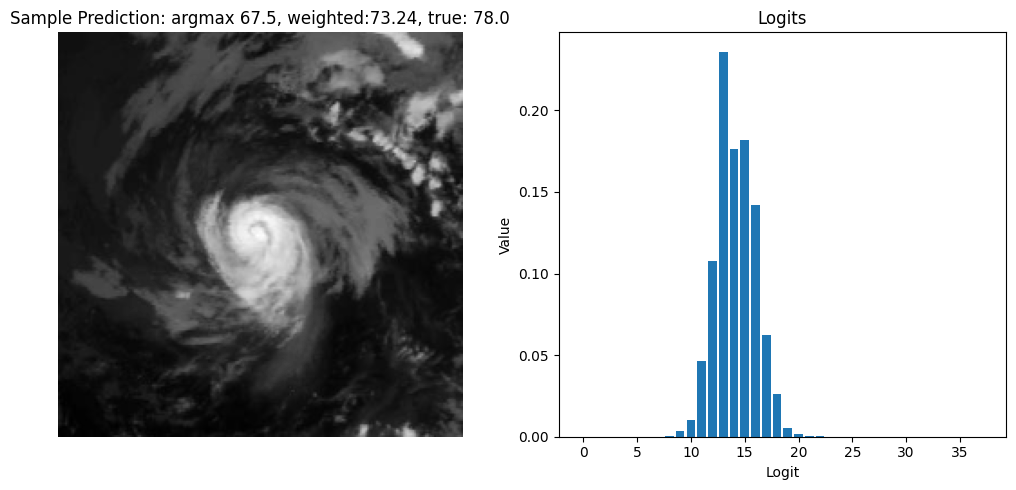

In [42]:
import matplotlib.pyplot as plt


def plot_method(all_test_pred_df, method: str, data_split: str):
    # Select rows for the given method
    df_method = all_test_pred_df[all_test_pred_df["uqmethod"] == method]
    df_method = df_method[df_method["split"] == f"preds_{data_split}"]

    # If there's no data for the given method, return
    if df_method.empty:
        print(f"No data for method: {method}")
        return

    # Select a random row (sample) from the dataframe
    sample = df_method.sample(1)

    # Extract logit columns (columns that start with 'logt_')
    logit_cols = [col for col in df_method.columns if col.startswith("logit_")]
    logits = sample[logit_cols].values[0]

    # Create a figure with two subplots: one for the prediction, one for the logits
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    print(sample)
    print(sample["index"].iloc[0])
    img = DS_DICT[data_split][int(sample["index"].iloc[0])]["input"]
    # Plot prediction
    axs[0].imshow(img[0, ...], cmap="gray")
    axs[0].set_title(
        f'Sample Prediction: argmax {sample["argmax_reg"].iloc[0]}, weighted:{sample["softmax_weighted_reg"].iloc[0]:.2f}, true: {sample["wind_speed"].iloc[0]}'
    )
    axs[0].set_xlabel("Index")
    axs[0].axis("off")
    axs[0].set_ylabel("Prediction")

    # Plot logits
    axs[1].bar(range(len(logit_cols)), logits)
    axs[1].set_title("Logits")
    axs[1].set_xlabel("Logit")
    axs[1].set_ylabel("Value")

    # Display the plot
    plt.tight_layout()
    plt.show()


plot_method(all_test_pred_df, "DUEClassification", DS_SPLIT)